# BTC DVOL Competition - Getting Started Guide

Welcome to the **BTC 30-Day Implied Volatility (DVOL) Prediction Competition**!

This notebook will guide you through the essential steps to understand the competition, set up your environment, build a model, and submit your predictions.

---

## 📊 What is This Competition?

**Objective:**  
Predict Bitcoin's 30-day implied volatility (DVOL) at multiple time horizon.

**Key Points:**
- **Target Variable:** BTC 30-day implied volatility from Deribit options market.
- **Prediction Horizons:** 1-hour, 24-hour ahead predictions.
- **Evaluation Metric:** Mean Squared Error (MSE) - lower is better.
- **Scoring:** Models are progressively scored at each step on a rolling 30-day window, with separate scores for 7-day (live), and 30-day (final) windows.

**Scoring Example:**
A prediction with horizon=3600s (1h) and step=900s (15min) makes 4 step-wise forecasts
- After 15 minutes, step 1 resolves → gets scored → contributes to leaderboard
- After 30 minutes, step 2 resolves → gets scored → updates leaderboard
- After 45 minutes, step 3 resolves
- After 60 minutes, step 4 resolves (full 1h horizon complete)

**Why This Matters:**
- Volatility prediction is crucial for options pricing and risk management in crypto markets.
- Your model will compete on a live leaderboard as predictions are made and actual DVOL is revealed.

---

## 🎯 High-Level Steps to Submission

1. **Set up your environment** with required libraries and API keys.
2. **Load historical DVOL data** from Deribit API or provided datasets.
3. **Explore the data** to understand patterns, trends, and seasonality.
4. **Build a predictive model** (baseline, machine learning, or hybrid approach).
5. **Validate your model** on historical data.
6. **Generate predictions** on recent/live data.
7. **Submit predictions** via the model orchestrator.
8. **Track your score** on the leaderboard.

---

## 📋 Rules

- **One Model Per Participant:** Each participant registers up to 2 model.
- **No Team:** No Team allowed during the competition.
- **Continuous Submission:** Models run continuously and make predictions at scheduled intervals.
- **Leaderboard:** Rankings are getting updated regularly daily based on MSE across all horizons.

Let's get started!

# 1. Set Up Your Environment

## Install Required Libraries

Install standard data science libraries **plus the competition package** (`btcvol`) from GitHub.

In [1]:
# Install required packages
import subprocess
import sys

packages = [
    'pandas',
    'numpy',
    'scikit-learn',
    'requests',
    'python-dateutil',
    'matplotlib',
    'seaborn',
    'btcvol'
]

for package in packages:
    try:
        __import__(package)
        print(f"✓ {package} already installed")
    except ImportError:
        print(f"Installing {package}...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
        print(f"✓ {package} installed successfully")

✓ pandas already installed
✓ numpy already installed
Installing scikit-learn...
✓ scikit-learn installed successfully
✓ requests already installed
Installing python-dateutil...
✓ python-dateutil installed successfully
✓ matplotlib already installed
✓ seaborn already installed
✓ btcvol already installed


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Competition package imports
from btcvol import TrackerBase, test_model_locally

# Display configuration
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully!")

✓ All libraries imported successfully!


# 2. Load and Explore Historical DVOL Data

Load the 15-minute DVOL dataset you uploaded (`DERIBIT_DVOL_15.csv`) and explore its structure.

In [4]:
from pathlib import Path

# Load 15-minute DVOL data from the uploaded CSV
data_path = Path("DERIBIT_DVOL_15.csv")
if not data_path.exists():
    alt_path = Path("notebooks") / "DERIBIT_DVOL_15.csv"
    if alt_path.exists():
        data_path = alt_path
    else:
        raise FileNotFoundError("DERIBIT_DVOL_15.csv not found in notebook or project root")

df_raw = pd.read_csv(data_path)

# Parse timestamps and sort
df_raw["time"] = pd.to_datetime(df_raw["time"], utc=True)
df_raw = df_raw.sort_values("time").reset_index(drop=True)

# Ensure numeric columns
for col in ["open", "high", "low", "close"]:
    df_raw[col] = pd.to_numeric(df_raw[col], errors="coerce")

# Use close as DVOL target
df_dvol = df_raw.rename(columns={"time": "timestamp"})
df_dvol["dvol"] = df_dvol["close"]

print("✓ Loaded 15-minute DVOL data")
print("Rows:", len(df_dvol))
print("Columns:", df_dvol.columns.tolist())
print("Date range:", df_dvol["timestamp"].min(), "→", df_dvol["timestamp"].max())

✓ Loaded 15-minute DVOL data
Rows: 42027
Columns: ['timestamp', 'open', 'high', 'low', 'close', 'dvol']
Date range: 2024-12-01 00:00:00+00:00 → 2026-02-11 18:30:00+00:00


In [6]:
# Quick data quality checks and summary

# Ensure timestamp dtype
if not pd.api.types.is_datetime64_any_dtype(df_dvol["timestamp"]):
    df_dvol["timestamp"] = pd.to_datetime(df_dvol["timestamp"], utc=True)

print("BTC DVOL Data Shape:", df_dvol.shape)
print("\nFirst 5 rows:")
print(df_dvol.head())
print("\nLast 5 rows:")
print(df_dvol.tail())

# Missing values
print("\nMissing Values:")
print(df_dvol[["timestamp", "open", "high", "low", "close", "dvol"]].isnull().sum())

# Duplicate timestamps
dup_count = df_dvol["timestamp"].duplicated().sum()
print("\nDuplicate timestamps:", dup_count)

# Expected frequency check (15 minutes)
time_deltas = df_dvol["timestamp"].diff().dropna()
print("\nMost common time delta:", time_deltas.mode().iloc[0])

# Basic statistics
print("\nDVOL Statistics:")
print(df_dvol["dvol"].describe())

BTC DVOL Data Shape: (42027, 6)

First 5 rows:
                  timestamp   open   high    low  close   dvol
0 2024-12-01 00:00:00+00:00  55.17  55.21  55.13  55.13  55.13
1 2024-12-01 00:15:00+00:00  55.13  55.17  55.12  55.15  55.15
2 2024-12-01 00:30:00+00:00  55.15  55.46  55.14  55.46  55.46
3 2024-12-01 00:45:00+00:00  55.47  55.69  55.47  55.69  55.69
4 2024-12-01 01:00:00+00:00  55.69  55.86  55.69  55.86  55.86

Last 5 rows:
                      timestamp   open   high    low  close   dvol
42022 2026-02-11 17:30:00+00:00  55.77  55.80  55.71  55.80  55.80
42023 2026-02-11 17:45:00+00:00  55.80  55.83  55.75  55.79  55.79
42024 2026-02-11 18:00:00+00:00  55.79  56.19  55.79  56.01  56.01
42025 2026-02-11 18:15:00+00:00  56.01  56.01  55.78  55.85  55.85
42026 2026-02-11 18:30:00+00:00  55.85  56.00  55.85  55.95  55.95

Missing Values:
timestamp    0
open         0
high         0
low          0
close        0
dvol         0
dtype: int64

Duplicate timestamps: 0

Most common t

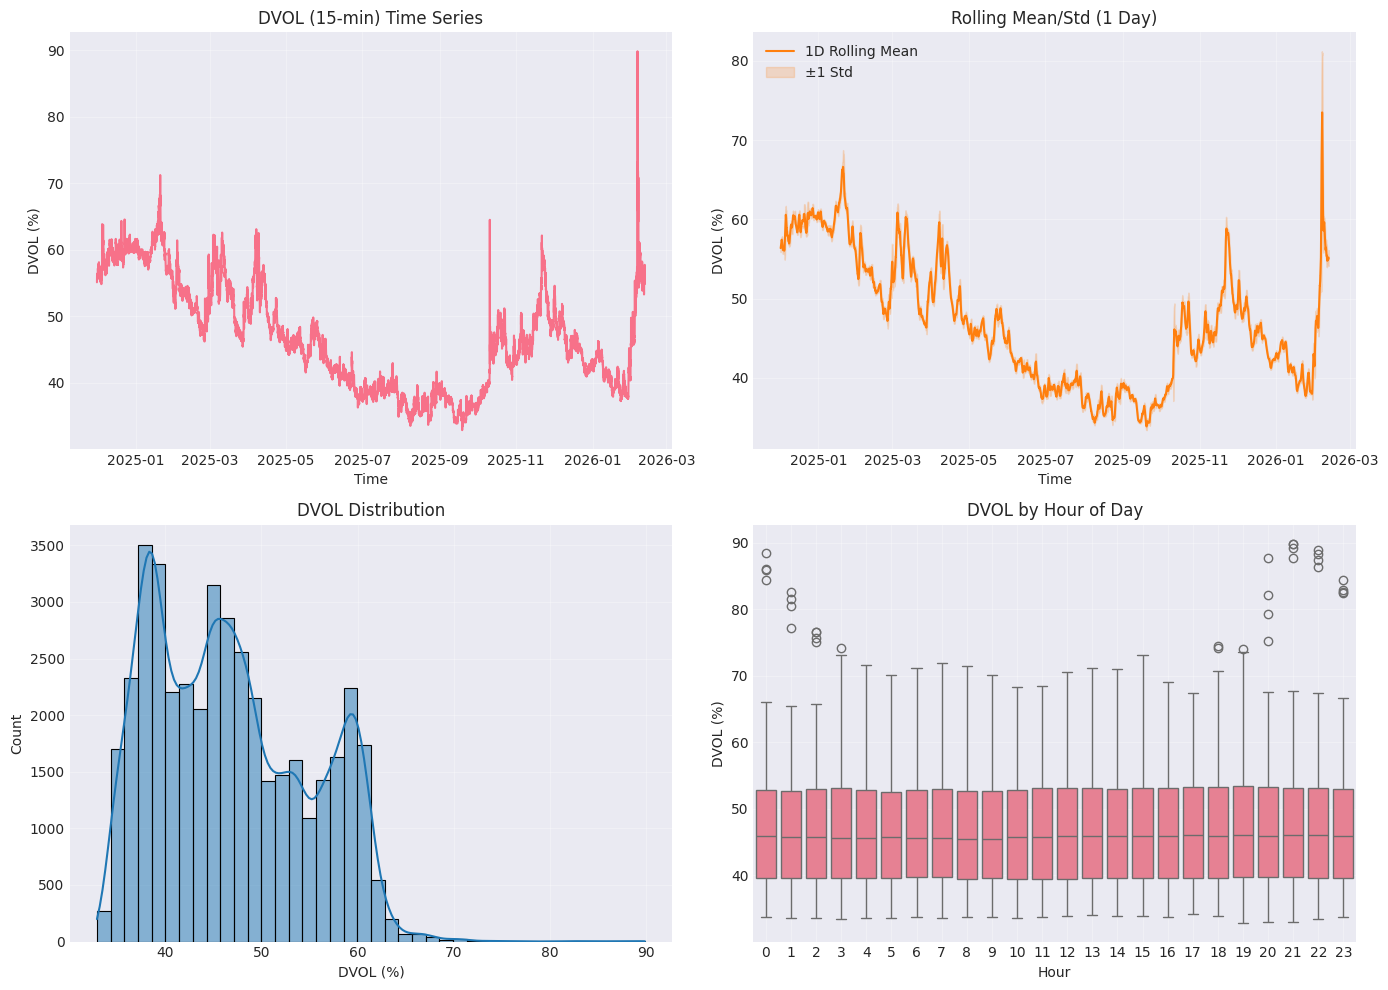


Missing Values:
open     0
high     0
low      0
close    0
dvol     0
dtype: int64


In [7]:
# Visualize DVOL time series and distributions

plot_df = df_dvol.copy()
if plot_df["timestamp"].dt.tz is not None:
    plot_df["timestamp"] = plot_df["timestamp"].dt.tz_convert(None)

# Rolling stats (1 day = 96 intervals of 15 minutes)
roll_window = 96
plot_df["dvol_roll_mean"] = plot_df["dvol"].rolling(roll_window).mean()
plot_df["dvol_roll_std"] = plot_df["dvol"].rolling(roll_window).std()

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1) DVOL over time
axes[0, 0].plot(plot_df["timestamp"], plot_df["dvol"], linewidth=1.5, label="DVOL (Close)")
axes[0, 0].set_title("DVOL (15-min) Time Series")
axes[0, 0].set_xlabel("Time")
axes[0, 0].set_ylabel("DVOL (%)")
axes[0, 0].grid(True, alpha=0.3)

# 2) Rolling mean and std bands
axes[0, 1].plot(plot_df["timestamp"], plot_df["dvol_roll_mean"], color="tab:orange", label="1D Rolling Mean")
axes[0, 1].fill_between(
    plot_df["timestamp"],
    plot_df["dvol_roll_mean"] - plot_df["dvol_roll_std"],
    plot_df["dvol_roll_mean"] + plot_df["dvol_roll_std"],
    color="tab:orange", alpha=0.2, label="±1 Std"
  )
axes[0, 1].set_title("Rolling Mean/Std (1 Day)")
axes[0, 1].set_xlabel("Time")
axes[0, 1].set_ylabel("DVOL (%)")
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend()

# 3) Distribution of DVOL
sns.histplot(plot_df["dvol"].dropna(), bins=40, kde=True, ax=axes[1, 0], color="tab:blue")
axes[1, 0].set_title("DVOL Distribution")
axes[1, 0].set_xlabel("DVOL (%)")
axes[1, 0].set_ylabel("Count")
axes[1, 0].grid(True, alpha=0.3)

# 4) DVOL by hour of day
plot_df["hour"] = plot_df["timestamp"].dt.hour
sns.boxplot(x="hour", y="dvol", data=plot_df, ax=axes[1, 1])
axes[1, 1].set_title("DVOL by Hour of Day")
axes[1, 1].set_xlabel("Hour")
axes[1, 1].set_ylabel("DVOL (%)")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Check for missing values in numeric columns
print("\nMissing Values:")
print(df_dvol[["open", "high", "low", "close", "dvol"]].isnull().sum())

# 3. Feature Engineering and Data Preparation

Create features for time-series prediction: lags, rolling statistics, and temporal features.

## Price Features (CrunchDAO Price API)

Price features are optional but can improve model performance by providing additional context about market conditions. Fetch BTC spot price data from CrunchDAO and merge with DVOL to build price-based features.

In [ ]:
# Fetch price data from CrunchDAO and merge with DVOL
def fetch_crunchdao_prices(asset, start_ts, end_ts, resolution="15minute", max_days=30):
    """
    Fetch price data from CrunchDAO Price API.
    https://pricedb.crunchdao.com
    """
    url = "https://pricedb.crunchdao.com/v1/prices"

    # Limit request size to avoid empty responses on large ranges
    if (end_ts - start_ts).days > max_days:
        start_ts = end_ts - pd.Timedelta(days=max_days)

    params = {
        "asset": asset,
        "resolution": resolution,
        "from": start_ts.isoformat(),
        "to": end_ts.isoformat()
    }

    response = requests.get(url, params=params, timeout=30)
    response.raise_for_status()
    payload = response.json()

    # API may return list or dict with data fields
    if isinstance(payload, dict):
        for key in ["data", "result", "prices", "items"]:
            if key in payload:
                data = payload[key]
                break
        else:
            data = payload
    else:
        data = payload

    if not isinstance(data, list) or len(data) == 0:
        raise ValueError("No price data returned from CrunchDAO API")

    df_price = pd.DataFrame(data)

    # Detect timestamp column
    ts_col = None
    for candidate in ["time", "timestamp", "ts", "datetime", "date"]:
        if candidate in df_price.columns:
            ts_col = candidate
            break

    if ts_col is None:
        raise ValueError(f"Could not find timestamp column in price data: {df_price.columns.tolist()}")

    df_price[ts_col] = pd.to_datetime(df_price[ts_col], utc=True)
    df_price = df_price.sort_values(ts_col).reset_index(drop=True)

    # Standardize column names
    rename_map = {ts_col: "timestamp"}
    for col in ["open", "high", "low", "close", "volume"]:
        if col in df_price.columns:
            rename_map[col] = f"price_{col}"
    df_price = df_price.rename(columns=rename_map)

    # Keep only known columns
    keep_cols = ["timestamp"] + [c for c in df_price.columns if c.startswith("price_")]
    df_price = df_price[keep_cols]

    return df_price


def _try_fetch_prices(asset, start_ts, end_ts, resolution):
    try:
        return fetch_crunchdao_prices(asset, start_ts, end_ts, resolution=resolution)
    except Exception as e:
        print(f"  First attempt failed: {e}")
        # Retry with a smaller window
        retry_start = end_ts - pd.Timedelta(days=7)
        print("  Retrying with last 7 days...")
        return fetch_crunchdao_prices(asset, retry_start, end_ts, resolution=resolution, max_days=7)


def fetch_prices_with_fallbacks(start_ts, end_ts):
    """
    Try multiple asset symbols and resolutions to match API expectations.
    """
    asset_candidates = ["BTC", "BTC-USD", "BTCUSD", "BTCUSDT"]
    resolution_candidates = ["15minute", "hour", "day"]

    last_error = None
    for asset in asset_candidates:
        for resolution in resolution_candidates:
            try:
                print(f"Trying asset={asset}, resolution={resolution}...")
                return _try_fetch_prices(asset, start_ts, end_ts, resolution=resolution)
            except Exception as e:
                last_error = e
                continue
    raise last_error or ValueError("No price data returned from CrunchDAO API")


# Fetch and merge price data with DVOL
start_ts = df_dvol["timestamp"].min()
end_ts = df_dvol["timestamp"].max()

try:
    df_price = fetch_prices_with_fallbacks(start_ts, end_ts)
    df_dvol = df_dvol.merge(df_price, on="timestamp", how="left")
    print("✓ Price data merged")
    print(df_price.head())
except Exception as e:
    print(f"✗ Price data fetch failed: {e}")
    print("Continuing without price features")

  First attempt failed: No price data returned from CrunchDAO API
  Retrying with last 7 days...
✗ Price data fetch failed: No price data returned from CrunchDAO API
Continuing without price features


In [32]:
# Create lag features (past values as predictors)
def create_features(data, lags=[1, 2, 3, 7], horizon_steps=96):
    """
    Create lag and rolling features for time-series prediction.
    """
    df = data.copy()

    # Lag features
    for lag in lags:
        df[f"lag_{lag}"] = df["dvol"].shift(lag)

    # Rolling mean features
    for window in [3, 7, 14]:
        df[f"rolling_mean_{window}"] = df["dvol"].rolling(window=window).mean().shift(1)

    # Rolling std features
    for window in [3, 7, 14]:
        df[f"rolling_std_{window}"] = df["dvol"].rolling(window=window).std().shift(1)

    # Price-based features (if available)
    if "price_close" in df.columns:
        df["price_return_1"] = df["price_close"].pct_change().shift(1)
        df["price_roll_mean_1d"] = df["price_close"].rolling(96).mean().shift(1)
        df["price_roll_std_1d"] = df["price_close"].rolling(96).std().shift(1)

    # Day of week and month (if applicable)
    df["day_of_week"] = df["timestamp"].dt.dayofweek
    df["day_of_month"] = df["timestamp"].dt.day

    # Target: DVOL 24 hours ahead (96 steps for 15-min data)
    df["target_dvol"] = df["dvol"].shift(-horizon_steps)

    # Remove rows with NaN values (created by lag features)
    df = df.dropna()

    return df

# Create features
df_features = create_features(df_dvol)

print("Features Created:")
print(df_features.head(10))
print("\nFeature Columns:", df_features.columns.tolist())

Features Created:
                   timestamp   open   high    low  close   dvol  lag_1  lag_2  \
14 2024-12-01 03:30:00+00:00  55.89  55.97  55.89  55.96  55.96  55.89  55.97   
15 2024-12-01 03:45:00+00:00  55.96  55.96  55.92  55.96  55.96  55.96  55.89   
16 2024-12-01 04:00:00+00:00  55.96  55.98  55.92  55.98  55.98  55.96  55.96   
17 2024-12-01 04:15:00+00:00  55.98  56.13  55.98  56.12  56.12  55.98  55.96   
18 2024-12-01 04:30:00+00:00  56.12  56.25  56.12  56.23  56.23  56.12  55.98   
19 2024-12-01 04:45:00+00:00  56.23  56.32  56.23  56.32  56.32  56.23  56.12   
20 2024-12-01 05:00:00+00:00  56.32  56.34  56.28  56.31  56.31  56.32  56.23   
21 2024-12-01 05:15:00+00:00  56.31  56.33  56.24  56.33  56.33  56.31  56.32   
22 2024-12-01 05:30:00+00:00  56.33  56.35  56.30  56.35  56.35  56.33  56.31   
23 2024-12-01 05:45:00+00:00  56.35  56.37  56.31  56.31  56.31  56.35  56.33   

    lag_3  lag_7  rolling_mean_3  rolling_mean_7  rolling_mean_14  \
14  56.13  55.91     

# 4. Build and Train Your Model

Train a simple machine learning model to predict DVOL. You can expand this with more sophisticated approaches (ARIMA, LSTM, etc.).

In [21]:
# Split data into train and test sets (80/20 split)
train_size = int(len(df_features) * 0.8)

df_train = df_features[:train_size]
df_test = df_features[train_size:]

# Separate features and target
feature_cols = [col for col in df_features.columns if col not in ["timestamp", "dvol", "target_dvol"]]

X_train = df_train[feature_cols]
y_train = df_train["target_dvol"]

X_test = df_test[feature_cols]
y_test = df_test["target_dvol"]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Number of features: {len(feature_cols)}")

Training set size: 33533
Test set size: 8384
Number of features: 16


In [22]:
# Train a Random Forest model
print("Training Random Forest model...")

# Normalize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
model = RandomForestRegressor(n_estimators=200, max_depth=5, random_state=42, n_jobs=-1)
model.fit(X_train_scaled, y_train)

print("✓ Model trained successfully!")

# Evaluate on training set
train_pred = model.predict(X_train_scaled)
train_mse = mean_squared_error(y_train, train_pred)
train_rmse = np.sqrt(train_mse)

print(f"\nTraining Performance:")
print(f"  MSE: {train_mse:.4f}")
print(f"  RMSE: {train_rmse:.4f}")

# Evaluate on test set
test_pred = model.predict(X_test_scaled)
test_mse = mean_squared_error(y_test, test_pred)
test_rmse = np.sqrt(test_mse)

print(f"\nTest Performance:")
print(f"  MSE: {test_mse:.4f}")
print(f"  RMSE: {test_rmse:.4f}")

Training Random Forest model...
✓ Model trained successfully!

Training Performance:
  MSE: 2.0068
  RMSE: 1.4166

Test Performance:
  MSE: 9.2357
  RMSE: 3.0390


Top 10 Most Important Features:
            feature  importance
3             close    0.308764
10  rolling_mean_14    0.252140
2               low    0.180585
1              high    0.144010
8    rolling_mean_3    0.042369
9    rolling_mean_7    0.039335
5             lag_2    0.008242
15     day_of_month    0.007281
4             lag_1    0.006194
0              open    0.005087


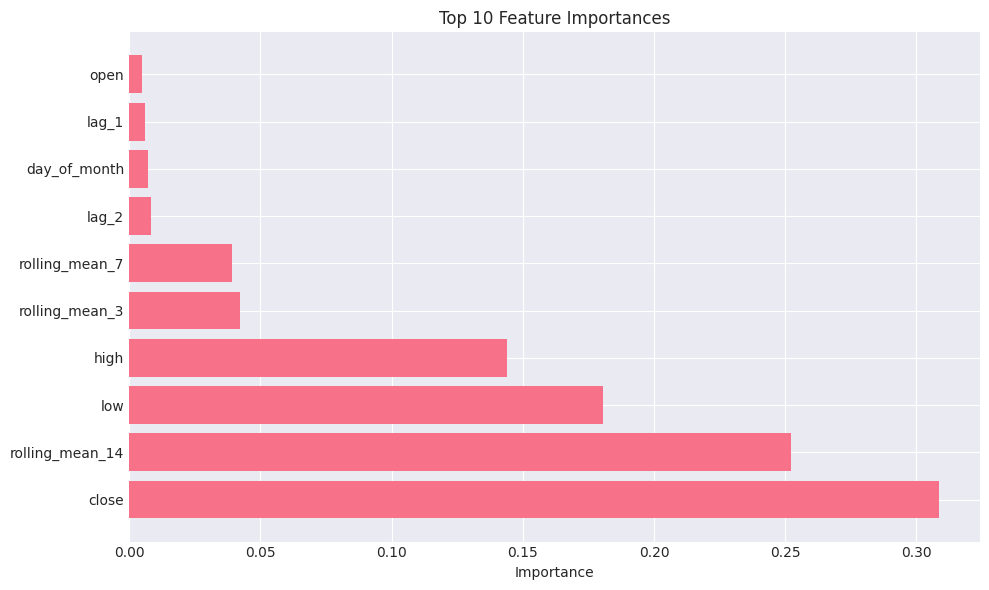

In [23]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['feature'].head(10), feature_importance['importance'].head(10))
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances')
plt.tight_layout()
plt.show()

# 5. Make Predictions

Generate predictions for the test set and visualize the results.

Predictions Sample:
                  timestamp  actual  predicted     error
0 2025-11-15 10:45:00+00:00   48.86  48.060305  0.799695
1 2025-11-15 11:00:00+00:00   48.85  48.060305  0.789695
2 2025-11-15 11:15:00+00:00   49.03  48.060305  0.969695
3 2025-11-15 11:30:00+00:00   49.00  48.060305  0.939695
4 2025-11-15 11:45:00+00:00   48.99  48.060305  0.929695
5 2025-11-15 12:00:00+00:00   48.96  48.060305  0.899695
6 2025-11-15 12:15:00+00:00   48.91  48.060305  0.849695
7 2025-11-15 12:30:00+00:00   48.93  48.060305  0.869695
8 2025-11-15 12:45:00+00:00   48.80  48.060305  0.739695
9 2025-11-15 13:00:00+00:00   48.79  48.060305  0.729695


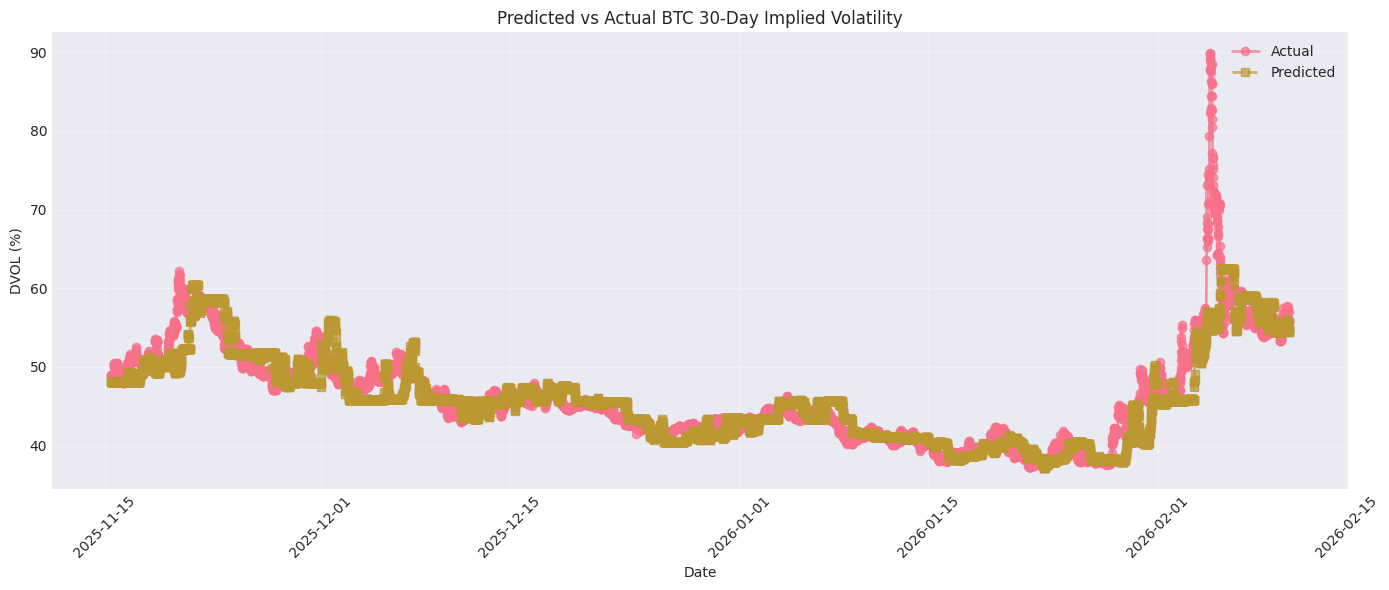

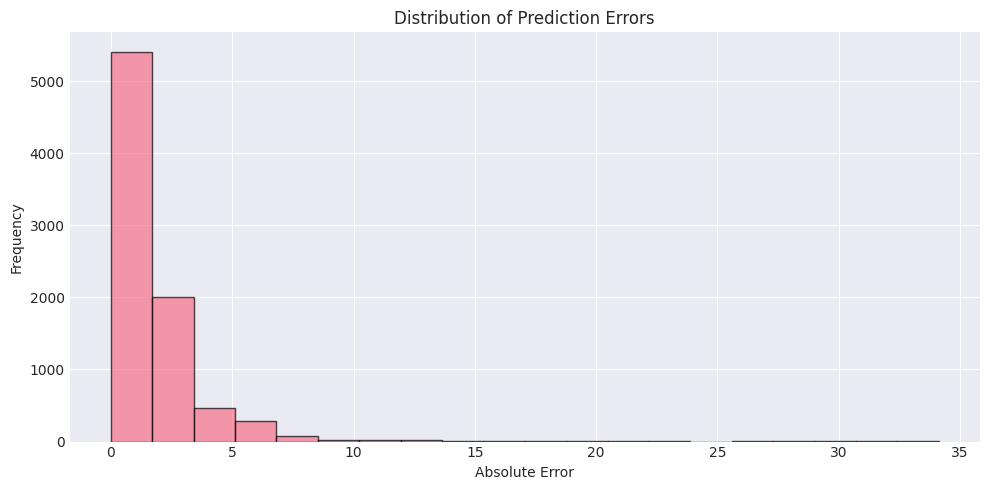

In [24]:
# Create predictions dataframe
predictions_df = pd.DataFrame({
    'timestamp': df_test['timestamp'].reset_index(drop=True),
    'actual': y_test.reset_index(drop=True),
    'predicted': test_pred,
    'error': np.abs(y_test.reset_index(drop=True) - test_pred)
})

print("Predictions Sample:")
print(predictions_df.head(10))

# Visualize predictions vs actual
plt.figure(figsize=(14, 6))
plt.plot(predictions_df['timestamp'], predictions_df['actual'], 'o-', label='Actual', alpha=0.7, linewidth=2)
plt.plot(predictions_df['timestamp'], predictions_df['predicted'], 's--', label='Predicted', alpha=0.7, linewidth=2)
plt.xlabel('Date')
plt.ylabel('DVOL (%)')
plt.title('Predicted vs Actual BTC 30-Day Implied Volatility')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Prediction error distribution
plt.figure(figsize=(10, 5))
plt.hist(predictions_df['error'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Absolute Error')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.tight_layout()
plt.show()

# 6. Prepare Your Submission (Model Code)

Submissions run your **model code** on the server (not a CSV file). Use the **btcvol** package (available on PyPI) to implement a tracker and validate it locally before uploading.

In [29]:
# Example tracker implementation using the trained Random Forest model
import numpy as np
from btcvol import TrackerBase, test_model_locally


class MyTracker(TrackerBase):
    """Random Forest tracker trained for the 24h horizon (86400s)."""

    def __init__(self, model=None, scaler=None, feature_cols=None):
        self.model = model or globals().get("model")
        self.scaler = scaler or globals().get("scaler")
        self.feature_cols = feature_cols or globals().get("feature_cols")

        if self.model is None or self.scaler is None or self.feature_cols is None:
            raise RuntimeError(
                "Model, scaler, or feature_cols not found. "
                "Run the training cells before using MyTracker."
            )

    def _latest_features(self):
        if "df_features" not in globals():
            raise RuntimeError("df_features not found. Run the feature engineering cell first.")
        return df_features.iloc[-1:][self.feature_cols]

    def _predict_24h_percent(self):
        X = self._latest_features()
        X_scaled = self.scaler.transform(X)
        return float(self.model.predict(X_scaled)[0])

    @staticmethod
    def _to_decimal(vol_percent):
        # Model trains on percent; competition expects decimal (e.g., 0.40 = 40%)
        return float(vol_percent) / 100.0

    def predict(self, asset: str, horizon: int, step: int):
        n_steps = max(1, horizon // step)
        pred_24h_pct = self._predict_24h_percent()

        if horizon == 86400:
            # 24h horizon (final score)
            pred_24h = self._to_decimal(pred_24h_pct)
            return [pred_24h] * n_steps
        if horizon == 3600:
            # 1h horizon required by validator: use a scaled 24h forecast
            # Simple heuristic: 1h vol is lower than 24h vol by sqrt(1/24)
            pred_1h_pct = pred_24h_pct / np.sqrt(24)
            pred_1h = self._to_decimal(pred_1h_pct)
            return [pred_1h] * n_steps

        raise ValueError("Unsupported horizon. Use 3600 or 86400 seconds.")




In [30]:
# Local validation (checks shape, numeric values, and reasonable range)
validation_ok = test_model_locally(MyTracker)
print("Validation passed:", validation_ok)

# Sanity check: sample outputs
tracker = MyTracker()
print(tracker.predict(asset="BTC", horizon=3600, step=900))
print(tracker.predict(asset="BTC", horizon=86400, step=900))


BTC DVOL Model Local Testing

✓ Model instantiation: PASSED
✓ Predict method exists: PASSED
✓ 1-hour predictions (4 values): PASSED
  Sample predictions: [0.11181661716308407, 0.11181661716308407, 0.11181661716308407, 0.11181661716308407]
✓ 24-hour predictions (96 values): PASSED
  Sample predictions: [0.5477873136273758, 0.5477873136273758, 0.5477873136273758, 0.5477873136273758, 0.5477873136273758]...

✓ All tests passed!

Your model is ready for submission to the competition.
Next steps:
  1. Review your predictions to ensure they make sense
  2. Test with historical data if available
  3. Submit to the competition platform

Validation passed: True
[0.11181661716308408, 0.11181661716308408, 0.11181661716308408, 0.11181661716308408]
[0.5477873136273758, 0.5477873136273758, 0.5477873136273758, 0.5477873136273758, 0.5477873136273758, 0.5477873136273758, 0.5477873136273758, 0.5477873136273758, 0.5477873136273758, 0.5477873136273758, 0.5477873136273758, 0.5477873136273758, 0.54778731362

# Submit your Notebook

To submit your work, you must:
1. Download your Notebook from Colab
2. Upload it to the platform
3. Create a run to validate it

### >> https://hub.crunchdao.com/competitions/synth/submit/notebook

![Download and Submit Notebook](https://raw.githubusercontent.com/crunchdao/competitions/refs/heads/master/documentation/animations/download-and-submit-notebook.gif)